In [1]:
# -*- coding: utf-8 -*- 
# This code is written in Python 3.7. To install the required packages, run the following commands:
# pip install pandas numpy matplotlib seaborn scikit-learn sympy
# This code is applicable to the mems dataset. 
# implemented KNeighbors Classifier Classifier. 

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns
import time
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout



2024-04-29 22:52:41.507581: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-29 22:52:41.546412: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-29 22:52:42.198589: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Load the cleaned Simargl 2022 dataset
df = pd.read_csv('/home/ibibers@ads.iu.edu/IOT/IOT_Datasets/mems_dataset.csv')


# Drop duplicates
df = df.drop_duplicates(keep='first')

# Drop columns that have just one unique value
one_value = df.columns[df.nunique() == 1]
df = df.drop(columns = one_value, axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21563 entries, 0 to 21575
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       21563 non-null  float64
 1   y       21563 non-null  float64
 2   z       21563 non-null  float64
 3   label   21563 non-null  int64  
dtypes: float64(3), int64(1)
memory usage: 842.3 KB


In [3]:
# X-axis: Represents acceleration along the horizontal axis.
# Y-axis: Represents acceleration along the vertical axis.
# Z-axis: Represents acceleration along the depth axis.

# labels 
#1. Normal: This label represents the state of the machine when it is operating under normal conditions, without any significant mechanical imbalance or impending failure.
#2. Near-failure: This label indicates that the machine is experiencing conditions that suggest it is close to a failure state. These conditions may include early signs of mechanical imbalance or other issues that could lead to failure if not addressed.
#3. Failure: This label is assigned when the machine has reached a state of failure, where it is no longer functioning as intended due to mechanical issues or other problems.


# Extract subsample of data
print (" Extract subsample of data: ")
print(df['label'].value_counts())

 Extract subsample of data: 
label
1    10955
2     5771
3     4837
Name: count, dtype: int64


In [4]:
dropped_df = ['label']
X = df.drop(dropped_df, axis=1)
y = df['label']


In [5]:
# Clear TensorFlow session
tf.keras.backend.clear_session()

In [6]:
start_time = time.time()

# Initial train test split set and split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Initialize MirroredStrategy for GPU acceleration
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    # Define the DNN model
    dnn_model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    # Compile the model
    dnn_model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

start_train_time = time.time()
# Train the model
history = dnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)
train_time = time.time() - start_train_time

start_pred_time = time.time()
# Make predictions
y_pred_proba = dnn_model.predict(X_test)
pred_time = time.time() - start_pred_time

# Convert predicted probabilities to binary predictions
y_pred_encoded = (y_pred_proba > 0.5).astype(int)

# Evaluate model performance
loss, accuracy = dnn_model.evaluate(X_test, y_test)

# Calculate total time
total_time = time.time() - start_time

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Epoch 1/10


2024-04-29 22:52:54.994838: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/ibibers@ads.iu.edu/micromamba/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-04-29 22:52:55.181000: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


370/378 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4839 - loss: -171.0037

2024-04-29 22:52:57.201228: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


378/378 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4845 - loss: -183.6585 - val_accuracy: 0.4909 - val_loss: -3052.5796
Epoch 2/10
 46/378 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4897 - loss: -3406.6296

2024-04-29 22:52:57.599251: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


368/378 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5093 - loss: -6228.5942

2024-04-29 22:52:58.825089: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


378/378 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5094 - loss: -6364.8291 - val_accuracy: 0.4909 - val_loss: -24346.4609
Epoch 3/10
 36/378 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5125 - loss: -23213.9551 

2024-04-29 22:52:59.115322: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


364/378 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5098 - loss: -33054.7031

2024-04-29 22:53:00.439142: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


378/378 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5099 - loss: -33549.4922 - val_accuracy: 0.4909 - val_loss: -78446.7969
Epoch 4/10
 22/378 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5106 - loss: -77778.1953  

2024-04-29 22:53:00.663345: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


366/378 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5139 - loss: -94390.5391

2024-04-29 22:53:02.001707: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


378/378 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5138 - loss: -95203.1797 - val_accuracy: 0.4909 - val_loss: -175868.4531
Epoch 5/10
 20/378 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4893 - loss: -178749.6875  

2024-04-29 22:53:02.278858: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


378/378 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5116 - loss: -203147.1719 - val_accuracy: 0.4909 - val_loss: -322225.8750
Epoch 6/10


2024-04-29 22:53:03.589009: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-04-29 22:53:03.743588: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


374/378 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5176 - loss: -349276.6875

2024-04-29 22:53:05.004439: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


378/378 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5176 - loss: -349924.2500 - val_accuracy: 0.4909 - val_loss: -521248.1250
Epoch 7/10
 20/378 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5233 - loss: -489177.3125  

2024-04-29 22:53:05.228730: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


378/378 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5118 - loss: -560446.5000 - val_accuracy: 0.4909 - val_loss: -781400.6875
Epoch 8/10


2024-04-29 22:53:06.572457: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-04-29 22:53:06.729064: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


369/378 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5121 - loss: -816605.4375

2024-04-29 22:53:07.969264: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


378/378 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5121 - loss: -818631.2500 - val_accuracy: 0.4909 - val_loss: -1101237.2500
Epoch 9/10
 40/378 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5178 - loss: -1044658.4375 

2024-04-29 22:53:08.240430: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


376/378 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5125 - loss: -1144811.1250

2024-04-29 22:53:09.513769: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


378/378 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5125 - loss: -1145540.5000 - val_accuracy: 0.4909 - val_loss: -1486302.1250
Epoch 10/10
 36/378 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4894 - loss: -1520888.8750 

2024-04-29 22:53:09.807276: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


378/378 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5080 - loss: -1571143.7500 - val_accuracy: 0.4909 - val_loss: -1942443.2500


2024-04-29 22:53:11.088994: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-04-29 22:53:11.245932: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
  1/203 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.5625 - loss: -1488370.0000

2024-04-29 22:53:11.692773: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5143 - loss: -1842325.0000


2024-04-29 22:53:12.356559: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


In [7]:

print("Time taken for training:{:f} seconds".format(train_time))
print("Time taken for prediction: {:f} seconds".format(pred_time))
print("Total time taken:{:f} seconds".format(total_time))

Time taken for training:16.168509 seconds
Time taken for prediction: 0.532622 seconds
Total time taken:17.428640 seconds


In [8]:
# Evaluate the model on the test set


loss, accuracy = dnn_model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:f}')
print(f'Test Accuracy: {accuracy:f}')

203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5143 - loss: -1842325.0000
Test Loss: -1884614.500000
Test Accuracy: 0.508116


2024-04-29 22:53:23.557801: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


In [9]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_encoded)
print(f"Accuracy: {accuracy}")

Accuracy: 0.5081156283815118


In [10]:
#  Classificaiton Report 
print("\nClassification Report:")
print(classification_report(y_test, y_pred_encoded))


Classification Report:
              precision    recall  f1-score   support

           1       0.51      1.00      0.67      3287
           2       0.00      0.00      0.00      1731
           3       0.00      0.00      0.00      1451

    accuracy                           0.51      6469
   macro avg       0.17      0.33      0.22      6469
weighted avg       0.26      0.51      0.34      6469



/home/ibibers@ads.iu.edu/micromamba/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibibers@ads.iu.edu/micromamba/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibibers@ads.iu.edu/micromamba/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

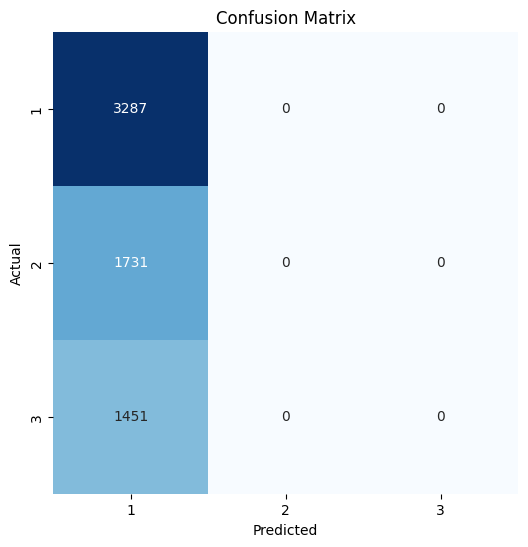

In [13]:
# Flatten y_pred_encoded if it has two dimensions
if y_pred_encoded.ndim > 1:
    y_pred_encoded = y_pred_encoded.flatten()

# Confusion matrix with string labels
conf_mat = confusion_matrix(y_test, y_pred_encoded)

# Get unique class labels from y_test and y_pred_encoded
unique_labels = np.unique(np.concatenate((y_test, y_pred_encoded)))

# Plotting the Confusion Matrix with class labels
plt.figure(figsize=(6, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred_encoded)
precision = precision_score(y_test, y_pred_encoded, average='macro')
recall = recall_score(y_test, y_pred_encoded, average='macro')
f1 = f1_score(y_test, y_pred_encoded, average='macro')
conf_matrix = confusion_matrix(y_test, y_pred_encoded)

# Print evaluation metrics
print("Prediction Evaluation:")
print("Accuracy: {:f}".format(accuracy))
print("Precision: {:f}".format(precision))
print("Recall: {:f}".format(recall))
print("F1-score: {:f}".format(f1))
print("Confusion Matrix:")
print(conf_matrix)


Prediction Evaluation:
Accuracy: 0.508116
Precision: 0.169372
Recall: 0.333333
F1-score: 0.224614
Confusion Matrix:
[[3287    0    0]
 [1731    0    0]
 [1451    0    0]]


/home/ibibers@ads.iu.edu/micromamba/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
